In [310]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import find_peaks

from sklearn.model_selection import train_test_split
from catboost import CatBoost


In [311]:
import os
#os.chdir("ECG_data")

In [312]:
files_num = 5
max_size = 20000
counter = 0

all_data = []
for filename in os.listdir():
    if filename.endswith(".csv") and counter < files_num: 
        print(os.path.join(filename))
        all_data.append(pd.read_csv(filename)[0:max_size])
        counter += 1
        continue
    else:
        continue

100.csv
101.csv
102.csv
103.csv
104.csv


Посмотрим на одном сигнале

In [313]:
data_settings = all_data[1]
columns = data_settings.columns
signal_setting = data_settings[columns[1]]
signal_setting = signal_setting[0:50000]

(0.0, 17500.0)

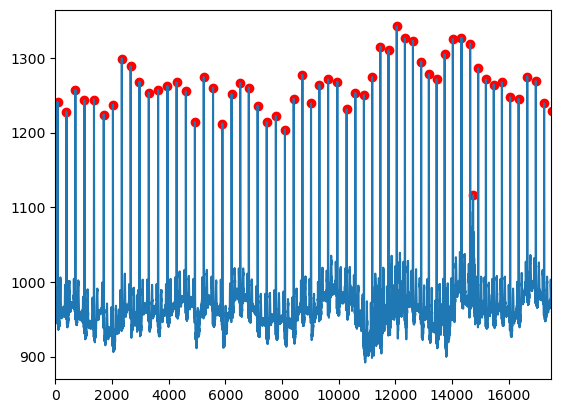

In [314]:

peaks = find_peaks(signal_setting, height=1100)
plt.plot(signal_setting)
plt.scatter(peaks[0], signal_setting[peaks[0]], color='red')
plt.xlim([0, 17500])

In [315]:
window_size = 300
stride = 8
y_lim = 0.1
x_lim = 10

In [316]:
def find_peaks_my(signal, peaks):
    dataset = []
    middles = []
    peak_count = 0
    for i in range(0, len(signal)-window_size, stride):
        norm_coef = np.max(np.abs(signal[i:i+window_size]))
        piece = signal[i:i+window_size] / norm_coef
        piece = piece - np.mean(piece)
        is_peak = 0
        middle = int((i + i + window_size) / 2)
        for peak in peaks[0]:
            if peak >= middle - x_lim and \
                peak < middle + x_lim and \
                (signal[peak] - signal[middle]) / norm_coef < y_lim:
                is_peak = 1
                peak_count += 1
                middles.append(middle)
                break
        piece = np.append(piece, is_peak)
    
        dataset.append(piece)
    return dataset, peak_count, middles

In [317]:
dataset, p_count, middles = find_peaks_my(signal = signal_setting, peaks=peaks)
df = pd.DataFrame(dataset)

(0.0, 2000.0)

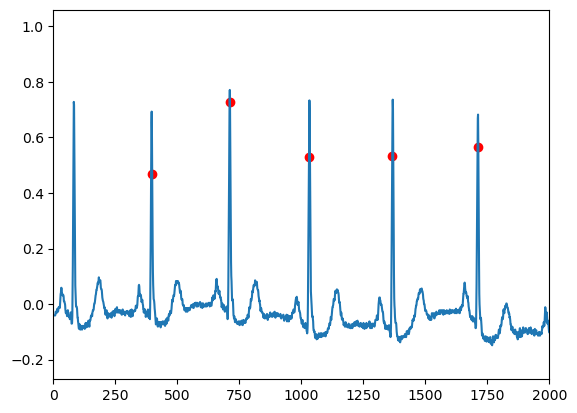

In [318]:
norm_sig = signal_setting - np.mean(signal_setting)
norm_sig = norm_sig / np.max(norm_sig)
plt.plot(norm_sig)
plt.scatter(middles, norm_sig[middles], color='red')
plt.xlim([0, 2000])

Осуществляем для остальных, склеиваем сигналы в один длинный

In [319]:
result_signal = []
for df in all_data:
    result_signal.extend(df[df.columns[1]])

print(len(result_signal))
peaks_all = find_peaks(result_signal, height=1100)

100000


In [320]:
dataset, p_count, middles = find_peaks_my(signal=result_signal, peaks=peaks_all)
df = pd.DataFrame(dataset)

(0.0, 40000.0)

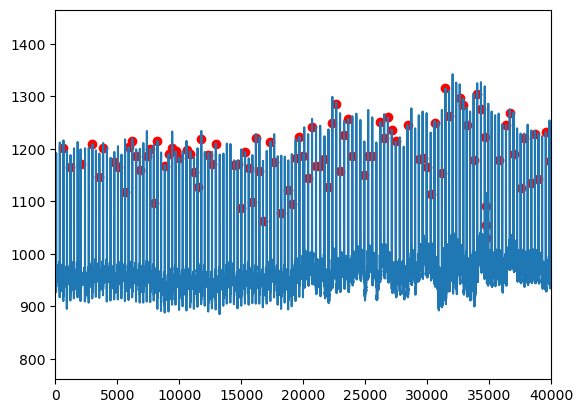

In [321]:
df_to_plot = pd.DataFrame(result_signal)
plt.plot(result_signal)
plt.scatter(middles[:p_count], df_to_plot[0][middles[:p_count]], color='red')
plt.xlim([0, 40000])

In [322]:
X_train, X_test, Y_train, Y_test = train_test_split(df.iloc[: , :window_size], df[window_size], test_size = 0.15)

booster = CatBoost(params={'iterations':100, 'loss_function':'Logloss'})

booster.fit(X_train, Y_train, eval_set=(X_test, Y_test))
booster.set_feature_names([str(i) for i in range(window_size)])

test_preds = booster.predict(X_test, prediction_type="Class")
train_preds = booster.predict(X_train, prediction_type="Class")

Learning rate set to 0.154557
0:	learn: 0.3819311	test: 0.3816477	best: 0.3816477 (0)	total: 56.4ms	remaining: 5.58s
1:	learn: 0.2072773	test: 0.2070783	best: 0.2070783 (1)	total: 107ms	remaining: 5.25s
2:	learn: 0.1136261	test: 0.1133460	best: 0.1133460 (2)	total: 158ms	remaining: 5.1s
3:	learn: 0.0754094	test: 0.0751602	best: 0.0751602 (3)	total: 209ms	remaining: 5.02s
4:	learn: 0.0520908	test: 0.0511616	best: 0.0511616 (4)	total: 267ms	remaining: 5.08s
5:	learn: 0.0399689	test: 0.0393990	best: 0.0393990 (5)	total: 317ms	remaining: 4.96s
6:	learn: 0.0333735	test: 0.0324189	best: 0.0324189 (6)	total: 366ms	remaining: 4.87s
7:	learn: 0.0280632	test: 0.0276461	best: 0.0276461 (7)	total: 417ms	remaining: 4.8s
8:	learn: 0.0245093	test: 0.0245461	best: 0.0245461 (8)	total: 467ms	remaining: 4.72s
9:	learn: 0.0220133	test: 0.0222890	best: 0.0222890 (9)	total: 519ms	remaining: 4.67s
10:	learn: 0.0200251	test: 0.0211323	best: 0.0211323 (10)	total: 567ms	remaining: 4.58s
11:	learn: 0.0177400	te

In [323]:
from catboost.utils import eval_metric
print("\nTest  Accuracy : %f"%eval_metric(Y_test.values, test_preds, "Accuracy")[0])
print("Train Accuracy : %f"%eval_metric(Y_train.values, train_preds, "Accuracy")[0])
print(len(Y_test.values))


Test  Accuracy : 0.996791
Train Accuracy : 0.999906
1870


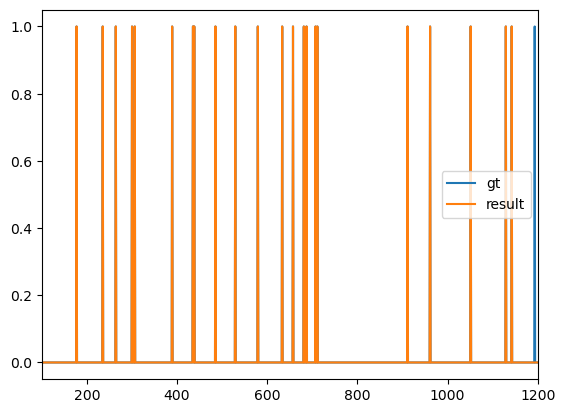

In [324]:
plt.plot(Y_test.values, label='gt')
plt.plot(test_preds, label='result')
plt.xlim([100, 1200])
plt.legend()

In [325]:
data_check = pd.read_csv('201.csv')
signal_check = data_check[columns[1]].values
signal_check = signal_check[0:50000]

In [326]:
dataset_check = []
middles_check = []
for i in range(0, len(signal_check)-window_size, stride):
    piece = signal_check[i:i+window_size] / np.max(np.abs(signal_check[i:i+window_size]))
    piece = piece - np.mean(piece)
    middle = (i + i + window_size) / 2
    middles_check.append(middle)
    dataset_check.append(piece)


In [327]:
df_check = pd.DataFrame(dataset_check)
test_preds = booster.predict(df_check, prediction_type="Class")

(0.0, 2500.0)

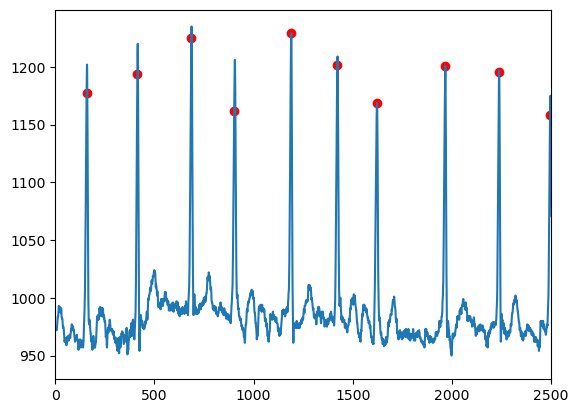

In [328]:
peaks_check = np.where(test_preds>0)[0]
middles_check = np.asarray(middles_check, dtype=int)
plt.plot(signal_check)
plt.scatter(middles_check[peaks_check], signal_check[middles_check[peaks_check]], color='red')
plt.xlim([0, 2500])

Вывод: из представленной информации можно сделать вывод, что при использовании пяти файлов для обучения модели можно достичь точности в 99 процентов.